In [1]:
from scipy.optimize         import newton
from sklearn.neighbors      import KDTree
from scipy.sparse           import csr_matrix
from scipy.sparse.csgraph   import dijkstra
from scipy.linalg           import eig
from sklearn.decomposition  import PCA
import numpy                as np
import gudhi                as gd
import warnings
import gurobipy             as gp
from gurobipy               import GRB
import matplotlib.pyplot    as plt
from kneed                  import KneeLocator
from scipy.spatial          import distance_matrix
from ripser                 import Rips
from sklearn.preprocessing  import PolynomialFeatures
import sympy                as sp
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem     import Problem
from pymoo.optimize         import minimize
import tadasets
import rml
from scipy.spatial import Delaunay
import triangle as tr

#%matplotlib qt

In [2]:
n_points = 1500

In [3]:
#params = {'max_components':5, 'S':0.5, 'k':10, 'threshold_var':0.05, 'edge_sen':1.5, 'k0':10, 'beta':[0.8, 3, 0.2, 0.2]}
params = {'max_components':5, 'S':0.5, 'k':10, 'threshold_var':0.05, 'edge_sen':2, 'k0':3, 'beta':None}

b_params = {'k':10, 'threshold_var':0.08, 'edge_sen':1, 'k0':10} 

In [33]:
sphere1 = tadasets.dsphere(n=int(n_points))

sphere5 = tadasets.dsphere(n=int(n_points*1.3))
sphere5 = sphere5[sphere5[:, 2]>=-0.7]

In [144]:
S = rml.Simplex()
S.build_simplex(sphere1, **params)
_ = S.normal_coords_trade(**params)

0
0


In [36]:
S_b = rml.Simplex()
S_b.build_simplex(S.coords, **b_params)

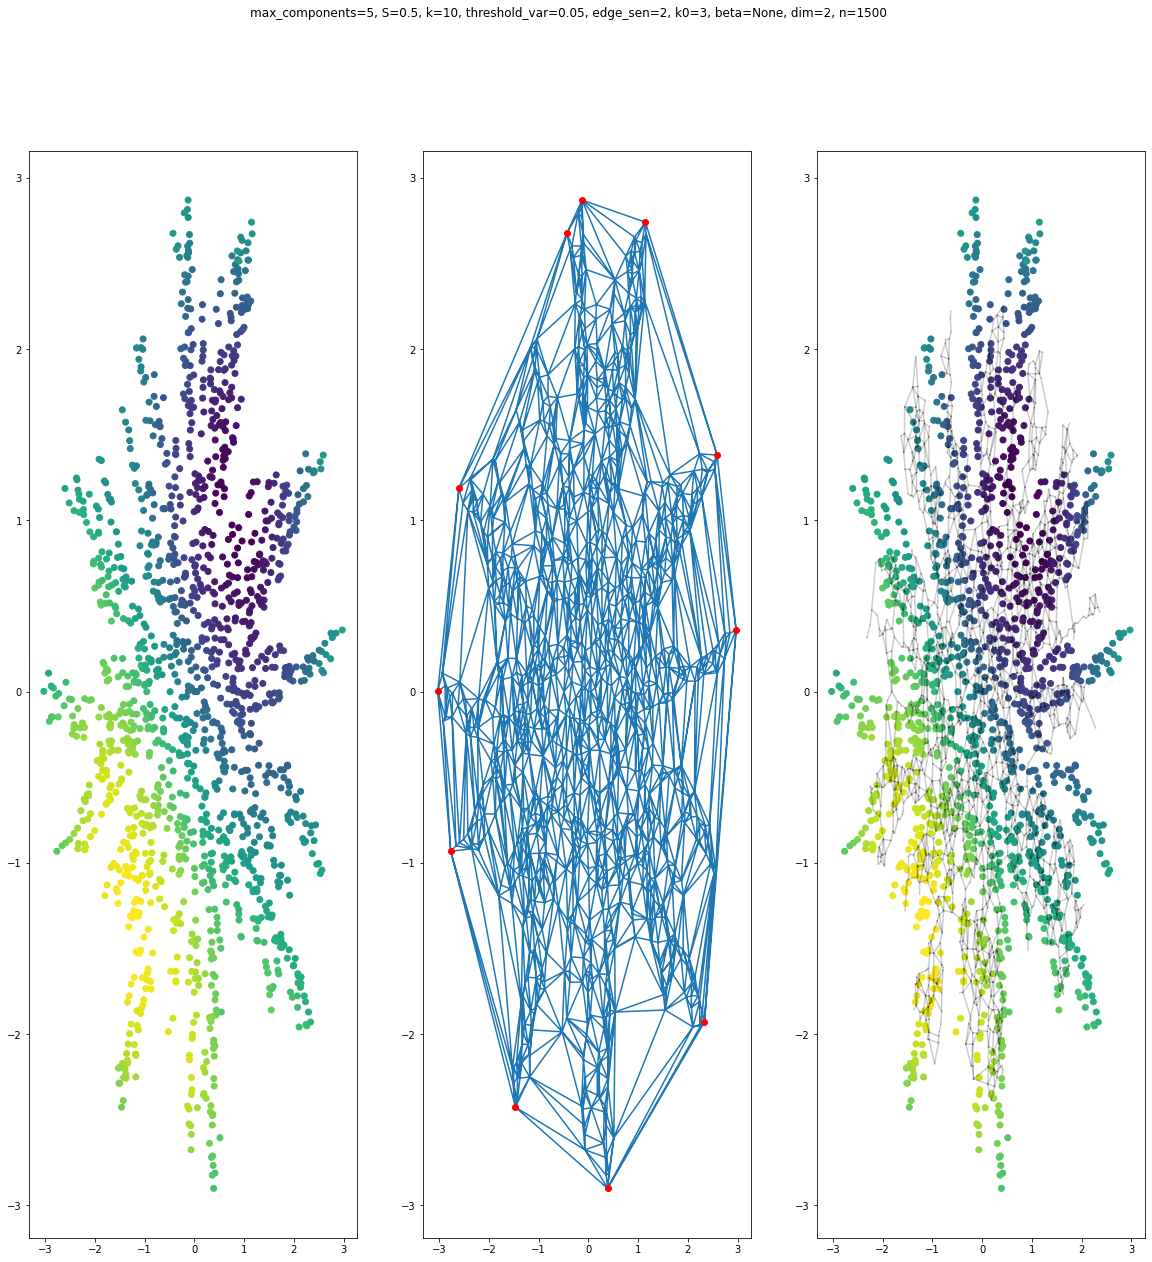

In [145]:
fig = plt.figure(figsize=(20, 20))
fig.suptitle(", ".join([i+"="+str(params[i]) for i in params.keys()]) + f', dim={S.dim}, n={n_points}')

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.scatter(S.coords[:, 0], S.coords[:, 1], c=S.pointcloud[:, 0])

tri = Delaunay(S.coords)
boundary = set()
for i in range(len(tri.neighbors)):
    for k in range(3):
        if (tri.neighbors[i][k] == -1):
            nk1,nk2 = (k+1)%3, (k+2)%3 
            boundary.add(tri.simplices[i][nk1])
            boundary.add(tri.simplices[i][nk2])

ax2.triplot(S.coords[:,0], S.coords[:,1], tri.simplices.copy())
ax2.plot(S.coords[list(boundary),0], S.coords[list(boundary),1], 'or')
#plt.scatter(S.coords[:,0], S.coords[:,1], c=S.pointcloud[:, 0])

ax3.scatter(S.coords[:, 0], S.coords[:, 1], c=S.pointcloud[:, 0])

for i in range(len(S_b.pointcloud)):
    for k in S_b.edges[i]:
        ax3.plot([S_b.pointcloud[i][0], S_b.pointcloud[k][0]],[S_b.pointcloud[i][1], S_b.pointcloud[k][1]], color='black', alpha=0.1)

plt.show()

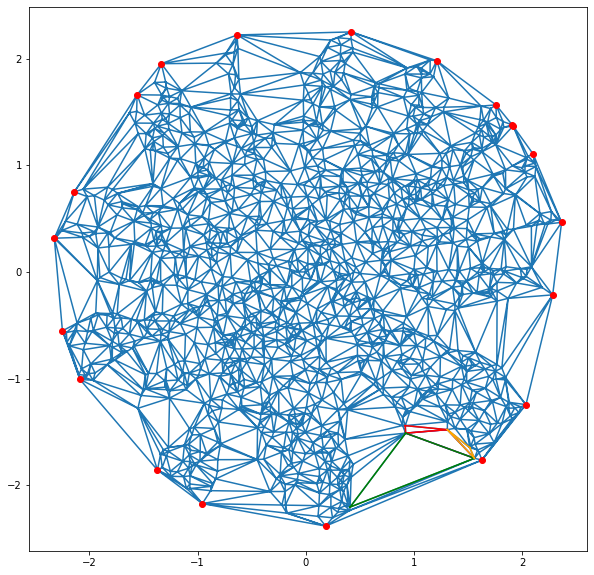

In [63]:
plt.figure(figsize=(10, 10))

plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices.copy())

#plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[0:1].copy())
#plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[41:42].copy())

plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[2:3].copy(), c='purple')

plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[176:177].copy(), c='red')
plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[12:13].copy(), c='g')
plt.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[2120:2121].copy(), c='orange')



plt.plot(S.coords[list(boundary),0], S.coords[list(boundary),1], 'or')

In [24]:
def circumcircle(T):
    """
    Computes centre and radius of circumcircle
    to triangle T
    """

    (x1, y1), (x2, y2), (x3, y3) = T
    A = np.array([[x3-x1,y3-y1],[x3-x2,y3-y2]])
    Y = np.array([(x3**2 + y3**2 - x1**2 - y1**2),(x3**2+y3**2 - x2**2-y2**2)])
    if np.linalg.det(A) == 0:
        return False
    Ainv = np.linalg.inv(A)
    X = 0.5*np.dot(Ainv,Y)
    x,y = X[0],X[1]
    r = np.sqrt((x-x1)**2+(y-y1)**2)
    return (x,y), r


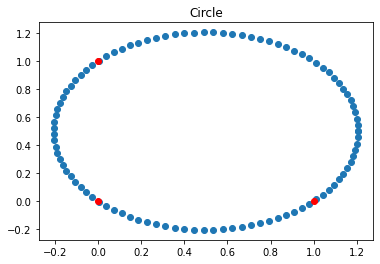

In [55]:
#T = ((0, 0), (1, 0), (0, 1))
T = np.array([[0, 0], [1, 0], [0, 1]])
(x, y), r = circumcircle(T)
#--> ((0.5, 0.5), 0.7071067811865476)

figure, axes = plt.subplots()
draw_circle = plt.Circle((x, y), r)
#axes.set_aspect()
#axes.add_artist(draw_circle)
u = np.linspace(0, 1, 100)
axes.scatter(r * (np.cos(2*np.pi*u))+x, r * (np.sin(2*np.pi*u)) + y)
axes.scatter(np.asarray(T)[:, 0], np.asarray(T)[:, 1], c='r')

plt.title('Circle')
plt.show()

In [22]:
def findRadiusOfIncircle(T):
    
    a = np.linalg.norm(T[1] - T[0])
    b = np.linalg.norm(T[2] - T[0])
    c = np.linalg.norm(T[2] - T[1])
 
    if (a < 0 or b < 0 or c < 0):
        return -1
 
    p = (a + b + c) / 2
 
    area = np.sqrt(p * (p - a) *
               (p - b) * (p - c))
 
    radius = area / p
 
    return radius

In [103]:
def refine_delaunay(S, ratio):
    tri = Delaunay(S.coords)
    safe_triangles = []
    for i, triangle_idxs in enumerate(tri.simplices):
        T = S.coords[triangle_idxs]
        #in_radius = findRadiusOfIncircle(T)
        #_, out_radius = circumcircle(T)
        #if out_radius / in_radius <= ratio:

        a = np.linalg.norm(T[1] - T[0])
        b = np.linalg.norm(T[2] - T[0])
        c = np.linalg.norm(T[2] - T[1])
 
        p = (a + b + c) / 3
        if p < ratio:
            safe_triangles.append(i)
    
    return safe_triangles

In [137]:
def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """

    #https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation

    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

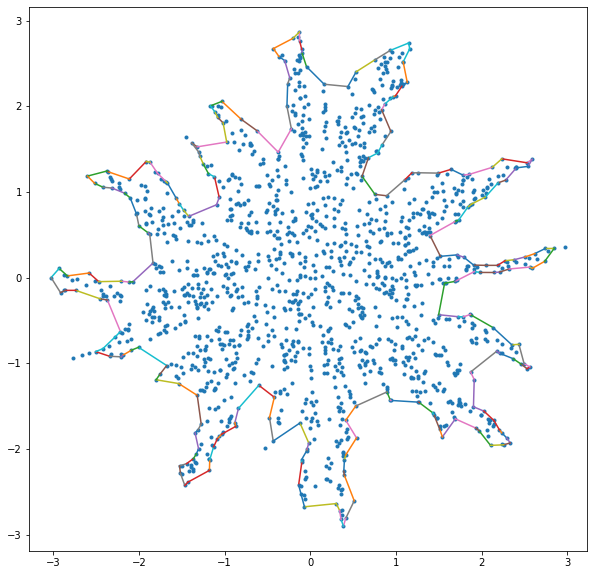

In [146]:
edges = alpha_shape(S.coords, alpha=0.2, only_outer=True)

# Plotting the output
plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.plot(S.coords[:, 0], S.coords[:, 1], '.')
for i, j in edges:
    plt.plot(S.coords[[i, j], 0], S.coords[[i, j], 1])
plt.show()

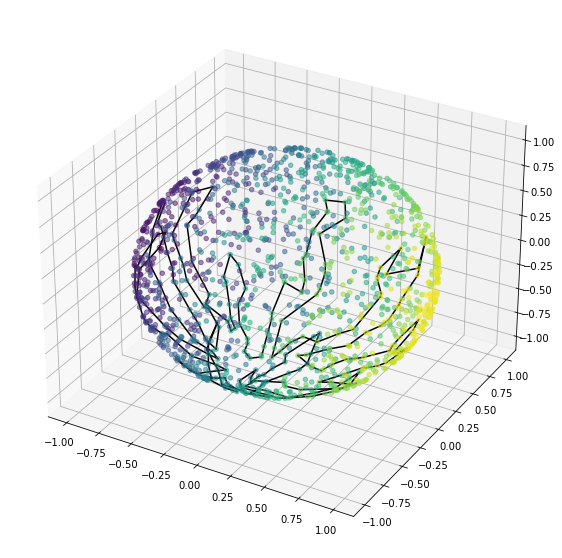

In [147]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter3D(S.pointcloud[:, 0], S.pointcloud[:, 1], S.pointcloud[:, 2], c=S.pointcloud[:, 0], alpha=0.5)

for i, j in edges:
    ax1.plot3D([S.pointcloud[i][0], S.pointcloud[j][0]],[S.pointcloud[i][1], S.pointcloud[j][1]], [S.pointcloud[i][2], S.pointcloud[j][2]], color='black')


In [131]:
_ = []
for triangle_idxs in tri.simplices:
    T = S.coords[triangle_idxs]
    a = np.linalg.norm(T[1] - T[0])
    b = np.linalg.norm(T[2] - T[0])
    c = np.linalg.norm(T[2] - T[1])
    p = (a + b + c) / 3
    _.append(p)    

In [132]:
np.mean(_)

0.11446862629807222

In [133]:
np.median(_)

0.09685791664292212

In [134]:
safe_triangles = refine_delaunay(S, 0.17)

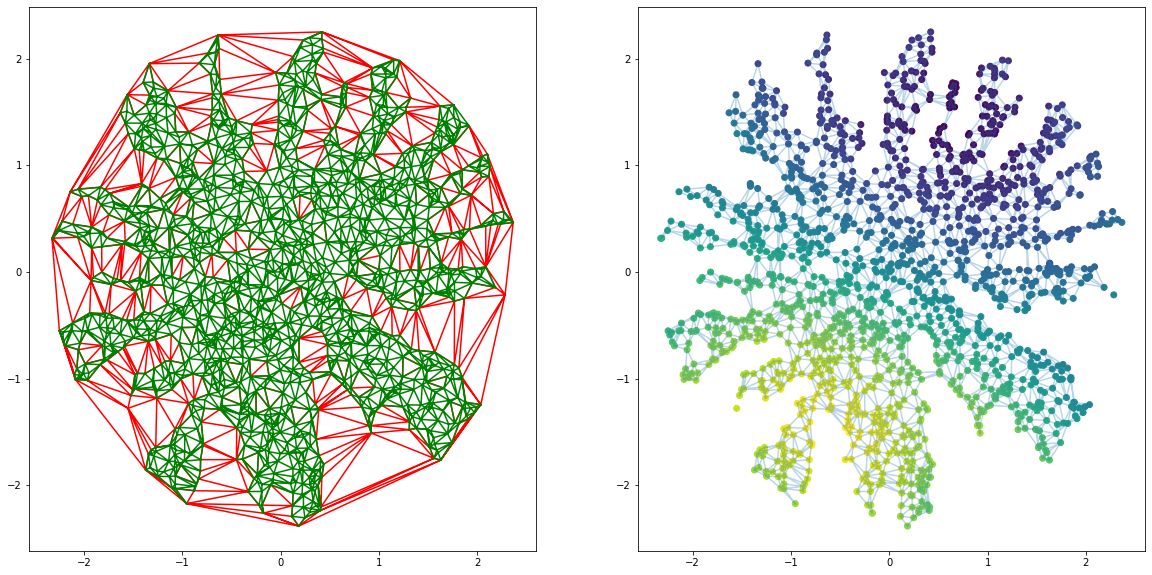

In [135]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

mask = np.zeros(len(tri.simplices),dtype=bool)
mask[safe_triangles] = True


ax1.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[~mask].copy(), c='r')
ax1.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[mask].copy(), c='g')  # safe triangles


ax2.triplot(S.coords[:,0], S.coords[:,1], tri.simplices[safe_triangles].copy(), alpha=0.3)
ax2.scatter(S.coords[:, 0], S.coords[:, 1], c=S.pointcloud[:, 0])

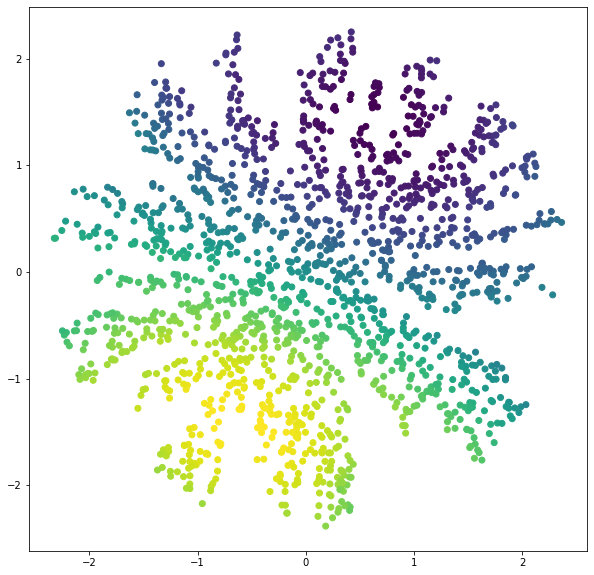

In [127]:
plt.figure(figsize=(10, 10))
plt.scatter(S.coords[:, 0], S.coords[:, 1], c=S.pointcloud[:, 0])

In [52]:
S.coords[tri.simplices[0]]

array([[ 1.62926646, -1.764767  ],
       [ 0.40564689, -2.2368405 ],
       [ 0.18419664, -2.38388226]])

In [5]:
def generate_disk(n, r=1):
    U1 = np.random.uniform(size = 10000)
    U2 = np.random.uniform(size = 10000)
    X = r * np.sqrt(U2) * np.cos(2 * np.pi * U1)
    Y = r * np.sqrt(U2) * np.sin(2 * np.pi * U1)

    return X, Y

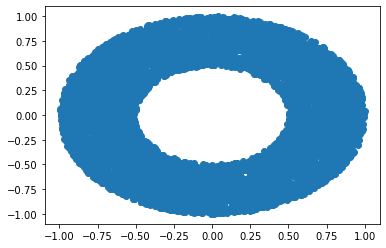

In [6]:
X, Y = generate_disk(1000)
disk_data = np.column_stack([X, Y])
annulus = disk_data[np.linalg.norm(disk_data, axis=1)>=0.5]
plt.scatter(annulus[:, 0], annulus[:, 1])

In [9]:
S_c = rml.Simplex()
S_c.build_simplex(annulus, **b_params)

p_idx, _ = S_c.normal_coords(**b_params)

GurobiError: Element 0 of a double array is Nan or Inf.

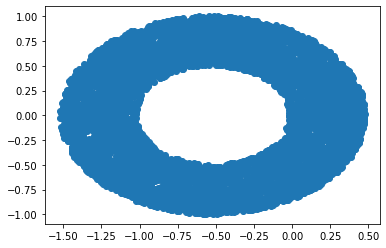

In [17]:
plt.scatter(S_c.coords[:, 0], S_c.coords[:, 1])